In [1]:
#!/usr/bin/env python
#-*- coding:utf-8 -*-
import sys
import os
import numpy as np
from PIL import Image

np.set_printoptions(suppress=True)

In [2]:
# A) =Вход=
# 1) 2 файла изображений стереопары (в некой папке img/):
# 20160824-174253-406-1.jpg
# 20160824-174253-406-2.jpg

# for ipynb
fname_left = 'img/20160825-143207-156-1.jpg'
fname_right = 'img/20160825-143207-156-2.jpg'

# for cmd line run
# fname_left = os.path.abspath(sys.argv[0])
# fname_right = os.path.abspath(sys.argv[1])

In [3]:
img_left = Image.open(fname_left).convert(mode='L')
img_right = Image.open(fname_right).convert(mode='L')
print """Images loaded as grayscale:
%s
%s""" % (fname_left, fname_right)

Images loaded as grayscale:
img/20160825-143207-156-1.jpg
img/20160825-143207-156-2.jpg


In [4]:
# 2) Конфигурация эксперимента
# Txt-файлы (в папке config) 
# * Аффинные+дисторсные коэффициенты для цифровой юстировки стереопары:
# файл aff_dist.txt: a, b, c, d, e, f, eps1, eps2 -- 8 коэффициентов

# rX = a*lX + b*lY + e - eps1*z_x(lX, lY) + eps2*z_x(rX, rY)
# rY = c*lX + d*lY + f - eps1*z_y(lX, lY) + eps2*z_y(rX, rY),
# where approximately(!):
# z_x = (x-x0)*[ (x-x0)^2 +(y-y0)^2 ] = z_x(rX, rY) = z_x(lX, lY)
# z_y = (y-y0)*[ (x-x0)^2 +(y-y0)^2 ] = z_y(rX, rY) = z_y(lY, lY)

align_coeffs = np.loadtxt('config/aff_dist.txt')

print 'Align coeeficients:\n', align_coeffs

Align coeeficients:
[   0.9949    0.0058   -0.0115    1.0016  247.9095   47.3994    0.        0.    ]


In [5]:
# * Расстояние между камерами, Угол обзора камер по оси Х (горизонтали), 
# Число градаций серого, Минимальная высота:

# файл settings.txt: cam_distance (17.0 (m)), cam_distance_err (0.5 (m)), 
# cam_viewangle (62.0 degrees), cam_viewangle_err (5.0 degrees), 
# num_shades (256 (px)), min_height (200 (m))

settings = np.loadtxt('config/settings.txt')

print 'Other settings: \n', settings

Other settings: 
[  17.     0.5   62.     5.   256.   200. ]


In [6]:
# 4) Желаемое количество измерений на стереопаре: num_measurements
# по умолчанию: 10
# 5) Размеры кусочков для анализа (px): piece_width, piece_height 
# по умолчанию: 200, 200

num_measurements = 10
piece_width = 200
piece_height = 200
print 'Number of measurements: ', num_measurements
print 'Width of search fragment:', piece_width
print 'Height of search fragment:', piece_height

Number of measurements:  10
Width of search fragment: 200
Height of search fragment: 200


In [7]:
# B) Алгоритм автоматизированного анализа стереопары

# a) Подготовка к анализу:
# -- Юстировка("Нормализация") изображений для возможности анализа.
a = align_coeffs[0];
b = align_coeffs[1];
c = align_coeffs[2];
d = align_coeffs[3];
e = align_coeffs[4];
f = align_coeffs[5];
eps1 = align_coeffs[6];
eps2 = align_coeffs[7];

In [8]:
det = a * d - b * c;
inv_a = d / det;
inv_b = -b / det;
inv_c = -c / det;
inv_d = a / det;

In [9]:
def affine_transform_point(x, y):
    return [b * y + x * a + e , d * y + x * c + f]

In [10]:
def apply_affine(img_left, img_right):
    width = img_left.width
    height = img_left.height
    
    aff_coord = np.zeros((4, 2))
#     affine transformation of the corner points
    aff_coord[0] = affine_transform_point(0, 0)
    aff_coord[1] = affine_transform_point(width, 0)
    aff_coord[2] = affine_transform_point(0, height)
    aff_coord[3] = affine_transform_point(width, height)
    
#     the rightmost (biggest by value) x-coordinate of the transformed
#     left-top and left-bottom x-coordinates
    x0 = int( max(aff_coord[0, 0], aff_coord[2, 0]) )
#     the lowermost (biggest by value) y-coordinate of the transformed
#     left-top and right-top y-coordinates
    y0 = int( max(aff_coord[0, 1], aff_coord[1, 1]) )
#     the leftmost (smallest by value) x-coordinate of the transformed
#     right-top and right-bottom x-coordinates
    x1 = int( min(aff_coord[1, 0], aff_coord[3, 0]) )
#     the uppermost (smallest by value) y-coordinate of the transformed
#     left-bottom and right-bottom y-coordinates
    y1 = int( min(aff_coord[2, 1], aff_coord[3, 1]) )
    
#     n_x0 -- x-coordinate of the new left-bot point
    n_x0 = int( max(0, x0) )
#     n_y0 -- y-coordinate of the new left-bot point
    n_y0 = int( max(0, y0) )
#     n_x1 -- x-coordinate of the new right-top point
    n_x1 = int( min(width, x1) )
#     n_y1 -- y-coordinate of the new right-top point
    n_y1 = int( min(height, y1) )
    
    nw = n_x1 - n_x0 # new width
    nh = n_y1 - n_y0 # new height
    
    new_left_img = Image.new(mode='L', size=(nw, nh))
    new_right_img = Image.new(mode='L', size=(nw, nh))
    
    # Load pixmaps
    l_pix = img_left.load()
    r_pix = img_right.load()
    nl_pix = new_left_img.load()
    nr_pix = new_right_img.load()
    
    
    
    for  y in xrange(n_y0, n_y1):
        for x in xrange(n_x0, n_x1):
# Let's calculate backwards our original coordinates of the left image
            orig_x = int( (x - e) * inv_a + (y - f) * inv_b )
            orig_y = int( (x - e) * inv_c + (y - f) * inv_d )
            
#             assert(0 <= orig_x <= width)
#             assert(0 <= orig_y <= height)
            
# paint new images with coordinates from (0,0) to (nw - 1, nh - 1)
            nl_pix[x - n_x0, y - n_y0] = l_pix[orig_x, orig_y]
            nr_pix[x - n_x0, y - n_y0] = r_pix[x, y]
    
    return (new_left_img, new_right_img)

In [11]:
# for i = 0..num_measurements: # num_measurements раз

# --  эксперимент по оценке высоты:
# --- Из центральной части 1ого изображения берем случаным образом кусочек 
# размером (piece_width, piece_height).
# Ищем ближайший кусочек на области из 2го изображения, соответствующей 
# минимальной высоте min_height, ближайший по морфологической форме к 
# искомому.
# --- Считаем горизонтальный сдвиг между левыми верхними углами кусочков,
# вычисляем дистанцию до облачности и погрешность.

# -- Дописываем результат эксперимента в последнюю строку соответствующего
# файла.
# endfor


In [12]:
img_left_n, img_right_n = apply_affine(img_left, img_right)

img_left = img_left_n
img_right = img_right_n

In [19]:
fname_left[:-4]+"_aff_applied.png"

'img/20160825-143207-156-1_aff_applied.png'

In [20]:
# img_left.save(fname_left[: -4] + "_aff_applied.png")
# img_right.save(fname_right[: -4] + "_aff_applied.png")

In [13]:
w = img_left.width
h = img_right.height

In [14]:
piece_x = np.random.randint(w / 4.0, 3 * w / 4.0)
piece_y = np.random.randint(h / 4.0, 3 * h / 4.0)
print w, h
print piece_x, piece_y

piece = img_left.crop((piece_x, piece_y, 
                 piece_x + piece_width, piece_y + piece_height))

2811 2257
1867 759


In [15]:
# typical Other settings: 
# [  17.     0.5   62.     5.   256.   200. ]
base = settings[0]
base_err = settings[1]
viewangle_x = settings[2] # in degrees
viewangle_x_err = settings[3] # in degrees
num_shades = int(settings[4])
min_height = settings[5]

resolution_x = img_left.width;
viewangle = np.pi * viewangle_x / 180.0


# mpd is Maximum Pixel Distance <--> Minimum cloud height(altitude)
mpd = base * resolution_x / (2 * np.tan(viewangle / 2.0) * min_height)
fac_x = 1; # reserve-coefficient
fac_y = 2; #reserve-coefficient

area_x = int(piece_x - fac_x * piece_width)
area_y = int(piece_y - fac_y * piece_height)
area_width = int(mpd + 2 * fac_x * piece_width)
area_height = int(2 * fac_y * piece_height)
print area_x, area_y
print area_width, area_height

# area to search on right image
area = img_right.crop( (area_x, area_y, 
                        area_x + area_width, area_y + area_height) ) 

1667 359
598 800


In [17]:
# All needed arrays
# piece === object
# image === area
fft_piece_input = np.zeros((area_height, area_width))
fft_piece_output = np.zeros((area_height, area_width), dtype=complex)

fft_area_input = np.zeros((area_height, area_width))
fft_area_output = np.zeros((area_height, area_width), dtype=complex)
fft_area_output_cached = np.zeros((area_height, area_width), dtype=complex)

fft_multiplied = np.zeros((area_height, area_width), dtype=complex)
ifft_result = np.zeros((area_height, area_width))                            

In [48]:
def calc_convolution(chi, sqr_img_flag):
    
    
    
    return res

In [55]:
def find_object(img, obj, num_shades):
    """Finds object 'obj' on image 'img' using num_shades shades of gray"""
    
    chi = np.zeros((num_shades, img_size), dtype=bool)
    obj_pm = obj.load()
    img_pm = img.load()
    
    for h in xrange(obj_height):
        for w in xrange(obj_width):
            color = obj_pm[w, h] / (256.0 / num_shades)
            index = (obj_height - h - 1)*img_width + (obj_width - w - 1)
            chi[color, index] = True;

# Let's count how many pixels have color == i
# chi_elements[i] -- number of grayscale object pixels that have color == i 
    chi_elements = np.zeros(num_shades)
    for i in xrange(num_shades):
        chi_elements[i] = sum(chi[i])    
    
    convolution = np.zeros((num_shades, img_size))
    for i in xrange(num_shades):
        if chi_elements[i] > 0:
            convolution[i] = calc_convolution(chi[i], false)
    
    f_chi = np.zeros(img_size, dtype=bool)
    for h in xrange(obj_height):
        for  w in xrange(obj_width):
            index = h * img_width + w
            f_chi[index] = True
    
    f = calc_convolution(f_chi, True)
    
    conv_offset_x = obj_width - 1
    conv_offset_y = obj_height - 1
    
#      ||f - Ph(f)||^2 -- numerator in tau fraction
    numerator = np.ones(img_size) * 1e100 # big default values
    for h in xrange(img_height - obj_height + 1):
        for w in xrange(img_width - obj_width + 1):
            index = img_width * h + w
            index_k = img_width * (h + conv_offset_y) + (w + conv_offset_x)
            s = 0
            for k in xrange(num_shades):
                if chi_elements[k] > 0:
                    s += convolution[k, index_k] * \
                        convolution[k, index_k] / float(chi_elements[k])
            
            numerator[index] = abs(f[index_k] - s)
            
    
#      ||Po(f) - Pn(f)||^2  -- denominator in tau fraction
    denominator = np.zeros(img_size)
    
    for h in xrange(img_height - obj_height + 1):
        for w in xrange(img_width - obj_width + 1):
            index = img_width * h + w
            index_k = img_width * (h + conv_offset_y) + (w + conv_offset_x)
            s = 0
            sum_i = 0
            sum_k = 0
            for k in xrange(num_shades):
                if chi_elements[k] > 0:
                    sum_i += convolution[k, index_k]
                    sum_k += chi_elements[k]
                    s += convolution[k, index_k] * \
                        convolution[k, index_k] / float(chi_elements[k])
            
            denominator[index] = s - sum_i * sum_i / float(sum_k)
            denominator[index] = abs(denominator[index])
    
    
    result = np.zeros(img_size)
    result = numerator / denominator
    
#     index of top-left corner with minimal tau
    index = np.argmin(result)
    
    # returns  (x, y)
    return (index % img_width, index / img_width)

In [56]:
img = area
obj = piece

img_width = img.width
img_height = img.height
img_size = img_width * img_height
obj_width = obj.width
obj_height = obj.height

# fft_object_input = fftw_alloc_real(img_size);
# fft_object_output = fftw_alloc_complex(img_size);
# fft_multiplied = fftw_alloc_complex(img_size);
# # r2c -- real to complex
# fft_object_plan = fftw_plan_dft_r2c_2d( img_height, img_width, fft_object_input, fft_object_output, 0);
# ifft_result = fftw_alloc_real(img_size);
# ifft_plan = fftw_plan_dft_c2r_2d( img_height, img_width, fft_multiplied, ifft_result, 0);

In [51]:
# result x, y -- координаты кусочка, найденного в области поиска area
res_x, res_y = find_object(area, piece, num_shades)

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

In [54]:
type(img_size)

int

In [ ]:
# Some trials/drafts below:

In [1]:
import numpy as np
np.set_printoptions(precision=4)

In [2]:
a = np.random.random((3, 3))
print a, '\n'
print np.fft.fft2(a), '\n'
print np.fft.ifft2( np.fft.fft2(a) ).real

[[ 0.5469  0.005   0.1949]
 [ 0.3783  0.5774  0.4574]
 [ 0.0042  0.3671  0.8449]] 

[[ 3.3763+0.j     -0.2939+0.4743j -0.2939-0.4743j]
 [-0.5678-0.1706j  0.3691-0.3913j  1.2658-0.4102j]
 [-0.5678+0.1706j  1.2658+0.4102j  0.3691+0.3913j]] 

[[ 0.5469  0.005   0.1949]
 [ 0.3783  0.5774  0.4574]
 [ 0.0042  0.3671  0.8449]]


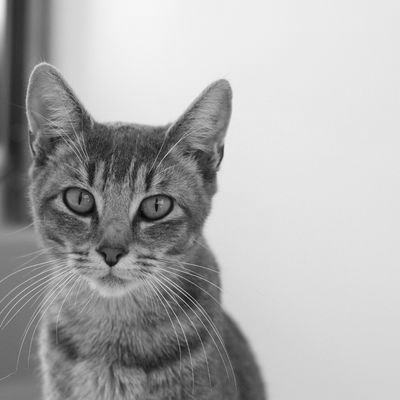

In [6]:
area = Image.open('img/catcare.jpg').convert('L')
area

In [7]:
area.size

(400, 400)

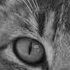

In [8]:
x = 50
y = 150
w = 70
h = 70
crop_box = (x, y, x+w, y+h)
frag = area.crop(crop_box)
frag

In [30]:
area_mat = np.asarray(area.getdata(), dtype=np.uint8).reshape((area.size[1], area.size[0]))
frag_mat = np.asarray(frag.getdata(), dtype=np.uint8).reshape((frag.size[1], frag.size[0]))

In [31]:
area_mat

array([[240, 236, 225, ..., 232, 232, 232],
       [240, 235, 224, ..., 232, 232, 232],
       [240, 235, 223, ..., 232, 232, 232],
       ..., 
       [120, 120, 120, ..., 211, 211, 211],
       [121, 121, 121, ..., 211, 211, 211],
       [122, 122, 122, ..., 211, 211, 211]], dtype=uint8)

In [32]:
frag_mat.shape

(70, 70)

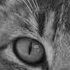

In [37]:
imf = Image.fromarray(frag_mat, 'L')
ima = Image.fromarray(area_mat, 'L')
imf

[[ 59  69  77 ...,  55  77  71]
 [ 53  69  83 ...,  57  99  90]
 [ 50  69  92 ...,  66  82  93]
 ..., 
 [ 90  98 100 ..., 110 111 112]
 [ 83  82  83 ..., 110 117 122]
 [ 74  75  82 ..., 100 108 115]]


/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


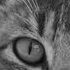

In [42]:
frag_fft2 = np.fft.fft2(frag_mat)
frag_ifft2 = np.fft.ifft2(frag_fft2).astype('uint8')
print frag_ifft2
imf1 = Image.fromarray(frag_ifft2, 'L')
imf1

In [47]:
# Create indicators 
t_chi = np.zeros([256] + list(area.size), dtype=bool)
t_chi.shape

(256, 400, 400)

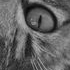

In [52]:
flip_frag = np.fliplr(frag_mat)
flip_frag = np.flipud(flip_frag)
Image.fromarray(flip_frag, 'L')

In [53]:
# Fill indicators
for h in xrange(flip_frag.shape[0]):
    for w in xrange(flip_frag.shape[1]):
        color = flip_frag[h, w]
        t_chi[color, h, w] = True

In [66]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
frag_fft2 = np.fft.fft2(flip_frag)
frag_ifft2 = np.fft.ifft2(frag_fft2).astype('uint8')
print frag_ifft2
imf1 = Image.fromarray(frag_ifft2, 'L')
imf1